In [1]:
import method.io
input_ids = ['101315', '170042', '160132', '155808', '144838',
             '141658', '134001', '111641', '135701', '151206']
broken_electrodes = [1, 12, 16]
input_values = []
filtered_datas = []

for input_id in input_ids:
    fi = 'input/' + input_id + '.txt'
    fd = 'data/' + input_id + '.txt'
    input_values.append(method.io.load_input(fi))

    # Load data
    raw_data = method.io.load(fd)
    filtered_data = method.io.mask(raw_data, x=broken_electrodes)
    filtered_datas.append(filtered_data)
    n_readout, n_stimuli = filtered_data.shape

In [2]:
import numpy as np
X_jstim = []
y_jstim = []
j_stim = 2
for i in range(len(input_ids)):
    for j in range(n_readout):
        if (j + 1) not in broken_electrodes + [j_stim + 1]:
            X_jstim.append(np.append(j, np.log(input_values[i]+1)))  # Here j might want to input x_j
            #X_jstim.append(np.append(j, i))
            y_jstim.append(filtered_datas[i][j, j_stim])

X_jstim = np.asarray(X_jstim)
y_jstim = np.asarray(y_jstim)

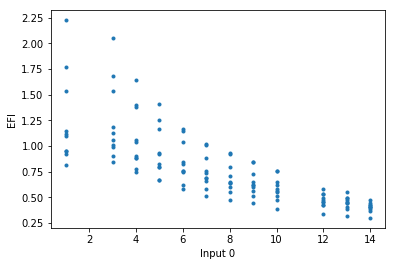

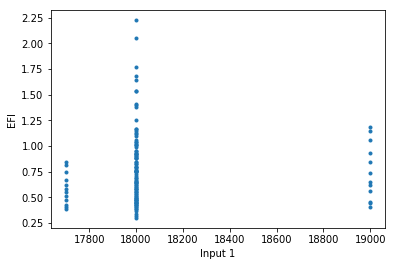

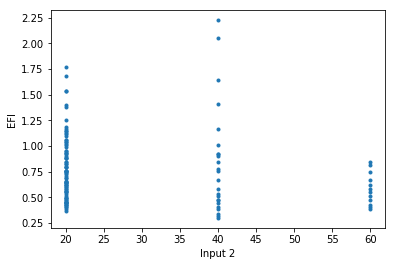

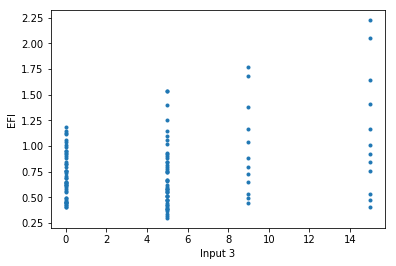

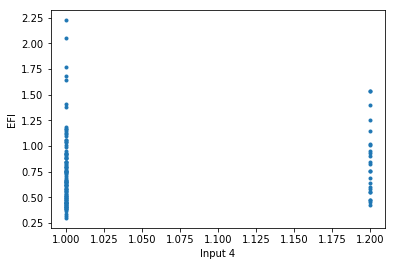

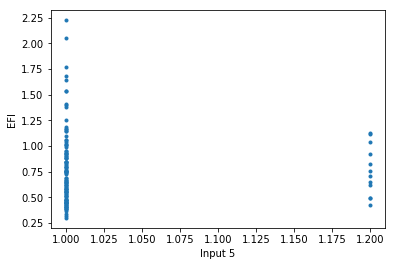

In [4]:
import matplotlib.pyplot as plt
for i in range(X_jstim.shape[1]):
    x = np.exp(X_jstim[:,i]) - 1 if i != 0 else X_jstim[:,i]
    plt.plot(x, y_jstim, '.')
    plt.ylabel('EFI')
    plt.xlabel('Input ' + str(i))
    plt.show()

In [5]:
import tensorflow as tf

In [6]:
def build_regression_model(
    input_neurons=10, input_dim=1, num_layers=1, architecture=[32], act_func="relu"
):
    """
  Builds a densely connected neural network model from user input
  
  Arguments
          num_layers: Number of hidden layers
          architecture: Architecture of the hidden layers (densely connected)
          act_func: Activation function. Could be 'relu', 'sigmoid', or 'tanh'.
          input_shape: Dimension of the input vector
  Returns
          A neural net (Keras) model for regression
  """
    if act_func == "relu":
        activation = tf.nn.relu
    elif act_func == "sigmoid":
        activation = tf.nn.sigmoid
    elif act_func == "tanh":
        activation = tf.nn.tanh

    layers = [
        tf.keras.layers.Dense(input_neurons, input_dim=input_dim, activation=activation)
    ]

    for i in range(num_layers):
        layers.append(tf.keras.layers.Dense(architecture[i], activation=activation))
    layers.append(tf.keras.layers.Dense(1))

    model = tf.keras.models.Sequential(layers)
    return model


def compile_train_regression_model(
    model,
    x_train,
    y_train,
    callbacks=None,
    learning_rate=0.001,
    batch_size=1,
    epochs=10,
    verbose=0,
):
    """
  Compiles and trains a given Keras model with the given data for regression. 
  Assumes Adam optimizer for this implementation.
  Assumes mean-squared-error loss
  
  Arguments
          learning_rate: Learning rate for the optimizer Adam
          batch_size: Batch size for the mini-batch operation
          epochs: Number of epochs to train
          verbose: Verbosity of the training process
  
  Returns
  A copy of the model
  """

    model_copy = model
    model_copy.compile(
        optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
        loss="mean_squared_error",
        metrics=["accuracy"],
    )
    if callbacks != None:
        model_copy.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[callbacks],
            verbose=verbose,
        )
    else:
        model_copy.fit(
            x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose
        )
    return model_copy

In [8]:
# Turn into 2D array
y_jstim = y_jstim.reshape(y_jstim.size, 1)

# Scale data
from sklearn.preprocessing import StandardScaler

scalerx = StandardScaler()
scalery = StandardScaler()

X_jstim_scaled = scalerx.fit_transform(X_jstim)
y_jstim_scaled = scalery.fit_transform(y_jstim)

In [13]:
# Single layer
architecture = [32]
input_neurons = 32
num_layers = 1
activation = 'relu'
input_dim = 6

nn_model = build_regression_model(input_neurons=input_neurons,num_layers=num_layers,
                                  architecture=architecture,input_dim=input_dim,
                                  act_func=activation)
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
_________________________________________________________________


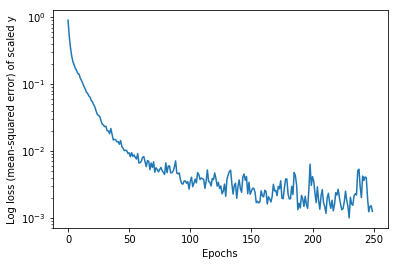

In [14]:
# Train with more bigger batch size
trained_model = compile_train_regression_model(nn_model,X_jstim_scaled,y_jstim_scaled,batch_size=4,verbose=0,epochs=250)

plt.figure()
plt.semilogy(trained_model.history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Log loss (mean-squared error) of scaled y")
plt.show()

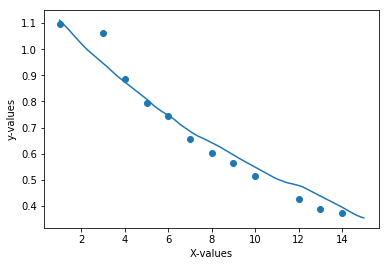

In [16]:
predict_k = 8
input_k_predict_x = [np.append(i, np.log(input_values[predict_k]+1)) for i in np.linspace(1, 15, 100)]
yhat = scalery.inverse_transform(trained_model.predict(scalerx.fit_transform(input_k_predict_x)))
y_test = filtered_datas[predict_k][:, j_stim]
X_test = range(n_readout)

plt.figure()
plt.scatter(X_test, y_test, label='actual values (test set)')
argsort = np.argsort(X_test, axis=0)
plt.plot(np.asarray(input_k_predict_x)[:, 0], yhat[:, 0], label='predicted values')
plt.xlabel("X-values")
plt.ylabel("y-values")
plt.show()

Model to predict:  [18500.0, 40.0, 9.0, 1, 1]
Data:  [1.8e+04 4.0e+01 5.0e+00 1.0e+00 1.0e+00] [1.9e+04 2.0e+01 0.0e+00 1.0e+00 1.0e+00]


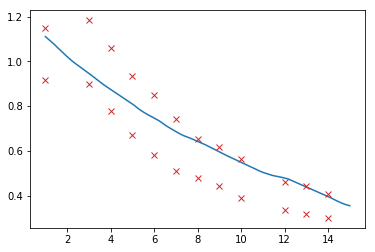

In [18]:
predict_new = [1, 5]
new_input_value = [1.85e4, 4e1, 9e0, 1, 1] #np.mean(np.asarray(input_values)[predict_new], axis=0)
print('Model to predict: ', new_input_value)
print('Data: ', input_values[predict_new[0]], input_values[predict_new[1]])
input_new_predict_x = [np.append(i, np.log(np.asarray(new_input_value)+1)) for i in np.linspace(1, 15, 100)]
yhat_new = scalery.inverse_transform(trained_model.predict(scalerx.fit_transform(input_k_predict_x)))

plt.plot(np.asarray(input_new_predict_x)[:, 0], yhat_new[:, 0], c='C0')
plt.plot(range(n_readout), filtered_datas[predict_new[0]][:, j_stim], 'x', c='C3')
plt.plot(range(n_readout), filtered_datas[predict_new[1]][:, j_stim], 'x', c='C3')
plt.show()